# The Traveling Salesperson Problem

The Travel Salesman Problem (TSP) consists mainly in an algorithmic problem tasked with finding the shortest route between a set of points and locations that must be visited. In the problem statement, the points are the cities a salesperson might visit.
This problem has been one of the oldest in history, since it is so complex as the number of cities increases, no solution has been found, regardless of the number of cities.
To understand this problem, it is necessary to be clear about some elements that it contains:


> *Given a set of cities and the distance between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*



- ***Given a set of cities***
<br>A Python `set` could represent a set of cities. An individual city might be just an integer index, or it might be (x, y) coordinates.
- ... ***and the distance between each pair of cities***: 
<br>We could use either a function, `distance(A, B),` or a table, `distance[A, B]`.
- ... ***what is the shortest possible tour***
<br>A tour is a sequential order in which to visit the cities; a function `shortest_tour(tours)` should find the one that minimizes `tour_length(tour)`, which is the sum of the distances between adjacent cities in the tour. 
- ... ***that visits each city once and returns to the starting city***
<br>Make sure a tour doesn't re-visit a city (except returning to the start). 




Norvig uses some libraries for the implementation of some of the algorithms, which are the following:


# ***Libraries and Functions***

In [1]:
# Imports used in this notebook. This is Python 3 on Jupyter with matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt
import random
from time        import clock 
from itertools   import permutations, combinations
from functools   import lru_cache as cache
from collections import Counter
from statistics  import mean, median

#Genetic Algorithm
%matplotlib inline
!pip install deap
!pip install tsplib95
!pip install pytictoc
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
import numpy
import random
import tsplib95
import urllib.request

     |████████████████████████████████| 160 kB 5.4 MB/s 


Just now, we´re going to put the function that we are going to use. 

In [2]:
'''Before starting, it is necessary to know what the variables of these functions are and what is inside them.

Tours: They are the valid routes through a set of cities, which will be a permutation between them. That means we can implement alltours with the built-in permutations function. The length of a tour is the sum of the distances between adjacent cities on the tour, the sum of the lengths of links between cities on the tour.

Cities: For this variable we only need to know the distance from one city to another. Of course, we must know the coordinates in a two-dimensional plane of each city.'''

alltours = permutations 
Tour = list

def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

City = complex

def distance(A, B): return abs(A - B)

def Cities(n, seed=123, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return frozenset(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))
    


'''We can see the tour between the cities in a more graphic way, and it is using plot.'''

def plot_tour(tour, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style)
    plot_segment(start, 'rD') # start city is red Diamond.
    
def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('off')
    
def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag


#DO FUNCTION
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0   = clock()
    tour = algorithm(cities)
    t1   = clock()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
    print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
          name(algorithm), len(tour), tour_length(tour), t1 - t0))
    
def name(algorithm): return algorithm.__name__.replace('_tsp', '')


#Another necesary functions

def reverse_segment_if_improvement(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A,B...C,D...], consider reversing B...C to get [...A,C...B,D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old links (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])
        return True


def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

def improve_nn_tsp(cities): 
    "Improve the tour produced by nn_tsp."
    return improve_tour(nn_tsp(cities))

def rep_improve_nn_tsp(cities, k=5):
    "Run nn_tsp from k different starts, improve each tour; keep the best."
    return shortest_tour(improve_tour(nn_tsp(cities, start)) 
                         for start in sample(cities, k))
    
@cache()
def bind(fn, *extra):
    "Bind extra arguments; also assign .__name__"
    newfn = lambda *args: fn(*args, *extra)
    newfn.__name__ = fn.__name__  + ''.join(', ' + str(x) for x in extra)
    return newfn  



def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

def join_endpoints(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg
    
#to use divide and conquer

def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

# TO DO: Data types: City, Cities, Tour; Functions: alltours, tour_length

def nn_tsp(cities, start=None):
    """Start the tour at the given start city (default: first city); 
    at each step extend the tour by moving from the previous city 
    to its nearest neighbor that has not yet been visited."""
    C = start or first(cities)
    tour = [C]
    unvisited = set(cities - {C})
    while unvisited:
        C = nearest_neighbor(C, unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def first(collection): return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda C: distance(C, A))

def join_endpoints(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

    
#To use the shoulder of giants

def shortest_links_first(cities):
    "Return all links between cities, sorted shortest first."
    return sorted(combinations(cities, 2), key=lambda link: distance(*link))



 The Usa map for the codes

In [3]:
def rep_nn_tsp(cities, k=25):
    "Repeat nn_tsp starting from k different cities; pick the shortest tour."
    return shortest_tour(nn_tsp(cities, start) for start in sample(cities, k))

def sample(population, k, seed=42):
    "Return a list of k elements sampled from population. Set random.seed."
    if k >= len(population): 
        return population
    else:
        random.seed((k, seed))
        return random.sample(population, k)


def continental_USA(line): 
    "Is this a line of the form '[TLA]  long lat City,ST'?"
    return line.startswith('[') and ',AK' not in line and ',HI' not in line
    
def parse_cities(lines, keep=continental_USA, long_scale=-48, lat_scale=69):
    """Make a set of Cities from lines of text."""
    return frozenset(City(long_scale * ncol(line, 2), lat_scale  * ncol(line, 1))
                     for line in lines if keep(line))


def ncol(line, n): "The number in the nth column"; return float(line.split()[n])


! [ -e latlong.htm ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm

USA = parse_cities(open('latlong.htm'))



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45102  100 45102    0     0   277k      0 --:--:-- --:--:-- --:--:--  277k


There are many algorithms that try to solve this problem. In this document we will talk about what each one is for, when to use them, how to implement them and what libraries they use.

# Exhaustive Search Algorithm: `exhaustive_tsp`

This algorithm is simply brute force, which is why it is a somewhat unnecessary algorithm because of how limited it is.
In the implementation that Norvig gives us, the number of cities that it gives as an example is nine, since as it is an algorithm that uses permutations to find each of its tours, it is advisable to use few cities.

> **Exhaustive Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest tour (the one with minimum tour length).*


In [4]:
def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

# TO DO: Data types: City, Cities, Tour; Functions: alltours, tour_length

Before starting, it is necessary to know what the variables of these functions are and what is inside them.

**Tours:** They are the valid routes through a set of cities, which will be a permutation between them. That means we can implement alltours with the built-in permutations function. The length of a tour is the sum of the distances between adjacent cities on the tour, the sum of the lengths of links between cities on the tour.

**Cities:** For this variable we only need to know the distance from one city to another. Of course, we must know the coordinates in a two-dimensional plane of each city.

**THE NEXT CODE IS IMPORTANT IN ANY ALGORITHM**

In [ ]:
alltours = permutations 

def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

City = complex

def distance(A, B): return abs(A - B)

def Cities(n, seed=123, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return frozenset(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))
    


# A solution!

The solution to visualize a tour of the city sets are complex numbers. First we have an real number followed by an imaginary number.



In [ ]:
exhaustive_tsp(Cities(9))

((158+421j),
 (297+397j),
 (832+102j),
 (872+207j),
 (817+315j),
 (939+600j),
 (620+498j),
 (163+639j),
 (31+501j))


## Visualizing results: `plot_tour` and `do`

We can see the tour between the cities in a more graphic way, and it is using plot.

**THE NEXT CODE IS IMPORTANT IN ANY ALGORITHM**


In [ ]:
def plot_tour(tour, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style)
    plot_segment(start, 'rD') # start city is red Diamond.
    
def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('off')
    
def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag

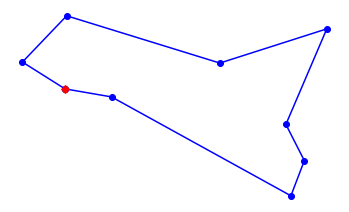

In [ ]:
plot_tour(exhaustive_tsp(Cities(9)))

In [ ]:
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0   = clock()
    tour = algorithm(cities)
    t1   = clock()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
    print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
          name(algorithm), len(tour), tour_length(tour), t1 - t0))
    
def name(algorithm): return algorithm.__name__.replace('_tsp', '')

To demonstrate the low efficiency of this algorithm to find the most optimal tour as we add more cities we have these examples:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


exhaustive: 9 cities ⇒ tour length 2450 (in 1.486 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


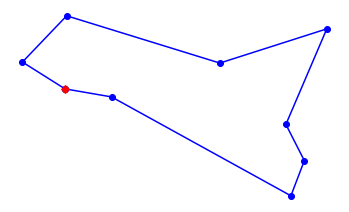

In [ ]:
do(exhaustive_tsp, Cities(9))

In the development environment that we ran, this algorithm took 1.2 seconds to give us the result of nine cities.

In [ ]:
do(exhaustive_tsp, Cities(10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

#Conclusion
By adding just one more city, the code takes 13 seconds to execute, so it is shown that this algorithm is not efficient and we want to find the most optimal route if there are many cities

We can verify that for 3 cities there are now only 2 tours, and that `exhaustive_tsp` can now do 10 cities in about the time it took to do 9 before:

# Nearest Neighbor Algorithm: `nn_tsp`

> **Nearest Neighbor Algorithm:** 
This algorithm was one of the pioneers in finding a solution to the TSP, this algorithm is mainly good at finding a close route, since it uses an approximation strategy and a greedy strategy, but its disadvantage is that it is not optimal.
What changes between exhaustive_tsp and this new one is that exhaustive_tsp is limited by the number of cities we want to tour, instead, this new one can get a tour of thousands of cities, but it is worth remembering that it is not always optimal.
Now, we will know some relevant data to understand the algorithm:


* ***Start at some city***  (pass the start city as an argument, or if `None`, use the first city in the set)
* ***... at each step extend the tour*** (using `tour.append`)
* ***... by moving from the previous city*** (`C`)
* ***...to its nearest neighbor*** (as given by the function `nearest_neighbor`)
* ***...that has not yet been visited*** (I will maintain a set of `unvisited` cities)


We will show the code step by step with its respective explanation.


These first three functions consist mainly of seeing nearby neighbors in order to choose this route. For that there is the nearest_neighbor() function and the nn_tsp() function looks at which neighbors have not been visited in order to choose them.

In [ ]:
def nn_tsp(cities, start=None):
    """Start the tour at the given start city (default: first city); 
    at each step extend the tour by moving from the previous city 
    to its nearest neighbor that has not yet been visited."""
    C = start or first(cities)
    tour = [C]
    unvisited = set(cities - {C})
    while unvisited:
        C = nearest_neighbor(C, unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def first(collection): return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda C: distance(C, A))

While `exhaustive_tsp` was limited to about a dozen cities, this algorithm can do thousands of cities in less than a second:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


nn: 1998 cities ⇒ tour length 33688 (in 0.621 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


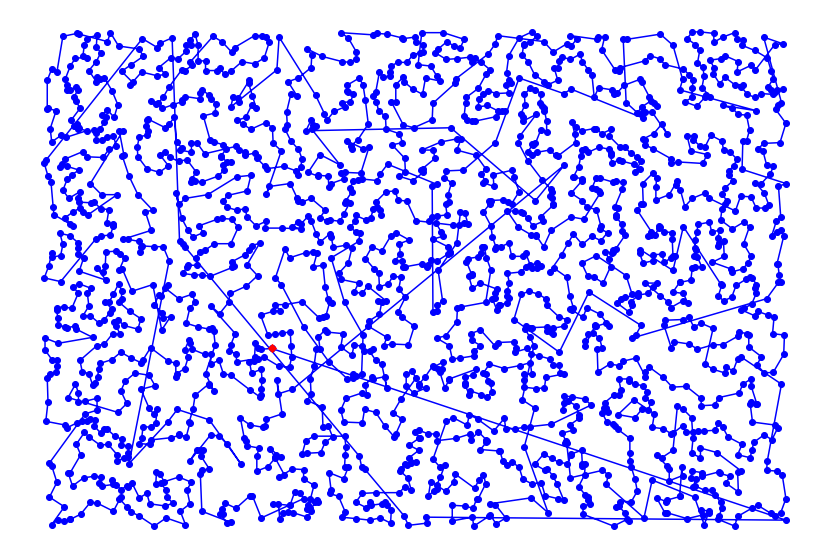

In [ ]:
do(nn_tsp, Cities(2000))

(Note: I asked for 2000 cities but only got 1998 distinct ones&mdash;sometimes the random number generator produces the exact same city.)

nn: 10 cities ⇒ tour length 2792 (in 0.000 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


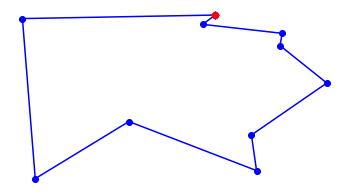

In [ ]:
do(nn_tsp, Cities(10))

In [ ]:
def rep_nn_tsp(cities, k=25):
    "Repeat nn_tsp starting from k different cities; pick the shortest tour."
    return shortest_tour(nn_tsp(cities, start) for start in sample(cities, k))

def sample(population, k, seed=42):
    "Return a list of k elements sampled from population. Set random.seed."
    if k >= len(population): 
        return population
    else:
        random.seed((k, seed))
        return random.sample(population, k)

To demonstrate that this code accepts thousands of cities we are going to download a file which contains the cities of the United States. The lines of code are the following:
The reason why long_scale=-48, lat_scale=69 are strictly like this, is because they took an average of the longitude and altitude of the cities of the United States, otherwise, we would have quite complex geometric figures

In [ ]:
def continental_USA(line): 
    "Is this a line of the form '[TLA]  long lat City,ST'?"
    return line.startswith('[') and ',AK' not in line and ',HI' not in line
    
def parse_cities(lines, keep=continental_USA, long_scale=-48, lat_scale=69):
    """Make a set of Cities from lines of text."""
    return frozenset(City(long_scale * ncol(line, 2), lat_scale  * ncol(line, 1))
                     for line in lines if keep(line))

def ncol(line, n): "The number in the nth column"; return float(line.split()[n])

In [ ]:
! [ -e latlong.htm ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm

USA = parse_cities(open('latlong.htm'))

#do(nn_tsp, USA)
#USA


# Improving Bad Links

We can improve this algorithm a bit and it is by correcting bad links from one city to another.
To demonstrate this, we have two examples. One is with bad links and the second is correcting it

# This codes also are importants to use another codes

nn: 10 cities ⇒ tour length 17 (in 0.000 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


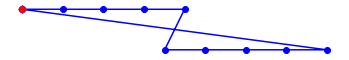

In [ ]:
cities10 = {City(x, 1) for x in range(0, 5)} | {City(x - 1.49, 0) for x in range(5, 10)}

do(nn_tsp, cities10)

The second is the following:

15.299342436137655

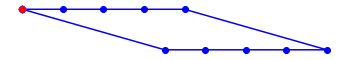

In [ ]:
tour = nn_tsp(cities10)

tour[5:10] = reversed(tour[5:10])

plot_tour(tour)
tour_length(tour)

With the first code, the tour has a length of 17, while the second has a length of 15.29. The difference is 1.71.
With this algorithm it is difficult not to make a mistake if its fundamental characteristic is to choose the nearest neighbor, therefore, an iterative improvement strategy is implemented.
This strategy consists mainly of the code continuing to run and choosing the nearest neighbor regardless of whether there is an error when choosing that neighbor, since at the end of the code when the tour is clearly seen we can correct the error, and this is simple because of the same strategy.


In [ ]:
def reverse_segment_if_improvement(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A,B...C,D...], consider reversing B...C to get [...A,C...B,D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old links (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])
        return True

Now we must implement the improve_tour() function, what it does is reverse until it finds the segment that could improve, and all this is done by brute force.

In [ ]:
def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

We will make a final demonstration to evaluate the optimization of the tour

**This code we will use later... **

# Improved Nearest Neighbor Algorithms

This improvement of the algorithm works on finding each candidate path from the iterative nearest neighbor algorithm:


In [ ]:
def improve_nn_tsp(cities): 
    "Improve the tour produced by nn_tsp."
    return improve_tour(nn_tsp(cities))

def rep_improve_nn_tsp(cities, k=5):
    "Run nn_tsp from k different starts, improve each tour; keep the best."
    return shortest_tour(improve_tour(nn_tsp(cities, start)) 
                         for start in sample(cities, k))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


improve_nn: 1089 cities ⇒ tour length 45489 (in 3.652 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


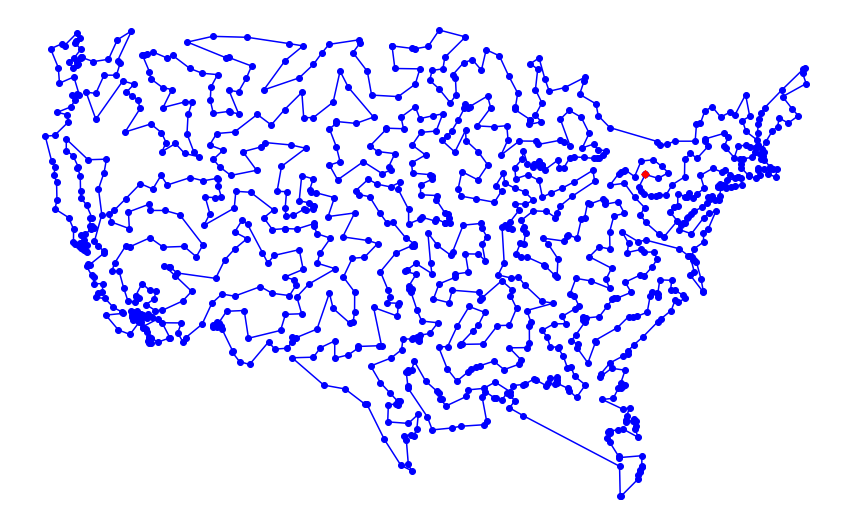

In [ ]:
do(improve_nn_tsp,  USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


rep_improve_nn: 1089 cities ⇒ tour length 44500 (in 21.756 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


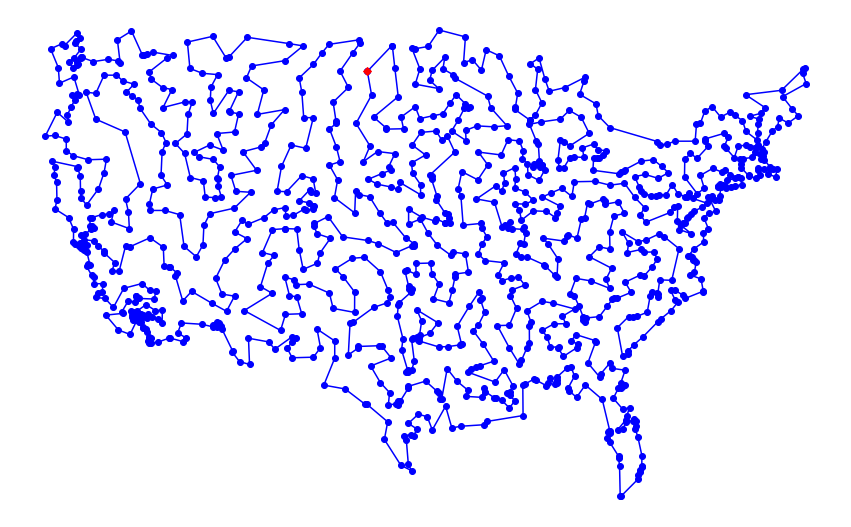

In [ ]:
do(rep_improve_nn_tsp, USA)

We can even improve the algorithm a bit, and it is to create a function in which we can do repetitions and thus we would have a more optimal tour

In [ ]:
@cache()
def bind(fn, *extra):
    "Bind extra arguments; also assign .__name__"
    newfn = lambda *args: fn(*args, *extra)
    newfn.__name__ = fn.__name__  + ''.join(', ' + str(x) for x in extra)
    return newfn

In [ ]:
do(bind(rep_improve_nn_tsp, 10), USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

Although this clearly takes much longer than the previous versions, we can see that the route is much more optimal.

# Greedy Algorithm: `greedy_tsp`

One way to use the greedy algorithm is to always take the shortest link possible from all the links between cities.
Then, a single route will no longer be made, but several, maintaining a set of segments and choosing the shortest each time.

The greedy algorithm consists of each city defining its own segment of 1 city. Find the shortest possible link that connects two ends of two different segments and join those segments with that link. Repeat until you form a single segment that runs through all the cities.

At each step of the algorithm, we want to *"find the shortest possible link connecting two endpoints".* This seems like an expensive operation at each step. So we'll add some data structures to speed up the computation:

Precompute a list of links, sorted by shortest link first. A link is a pair of cities: (A, B).
Keep a dict that assigns endpoints to segments, e.g. {A: [A, B, C], C: [A, B, C], D: [D]} means that A and C are the endpoints of the segment [A, B, C] and D is a 1- city ​​segment.
Go through the links in the shortest order. Suppose (B, D) is the next shortest link. We can't use it, because B is already joined to A and C. But if (A, D) is the next shortest, that works: A and D are endpoints of different segments, so we can join the two segments. Update the endpoint dict to reflect this new segment: {A: [D, A, B, C], D: [D, A, B, C]}.
Stop when the newly created segment contains all the cities.


In [ ]:
def greedy_tsp(cities):
    """Go through links, shortest first. Use a link to join segments if possible."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    for (A, B) in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            if len(new_segment) == len(cities):
                return new_segment
            
def improve_greedy_tsp(cities): return improve_tour(greedy_tsp(cities))
            
def shortest_links_first(cities):
    "Return all links between cities, sorted shortest first."
    return sorted(combinations(cities, 2), key=lambda link: distance(*link))
            
# TO DO: join_endpoints

**Note**: The endpoints dict has two purposes. The first is that it allows you to ask if a city A is an endpoint.

The second allows you to ask if endpoints A are different from B to ensure that the two cities are endpoints of different segments.

For the join_endpoints function, I first make sure that A is the last element of one segment and B is the first element of the other, reversing the segments if necessary. I then add segment B to the end of segment A. Finally, I update the endpoints statement by removing A and B and then adding the two endpoints of the new segment:

In [ ]:
def join_endpoints(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

Let's try out the `greedy_tsp` algorithm, with and without improvement, on the USA map:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


greedy: 1089 cities ⇒ tour length 46982 (in 0.770 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


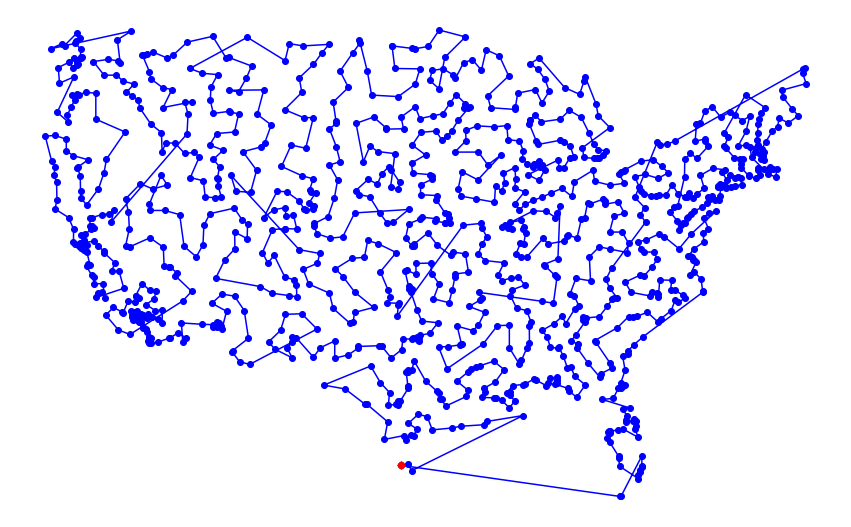

In [ ]:
do(greedy_tsp, USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


improve_greedy: 1089 cities ⇒ tour length 43844 (in 4.138 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


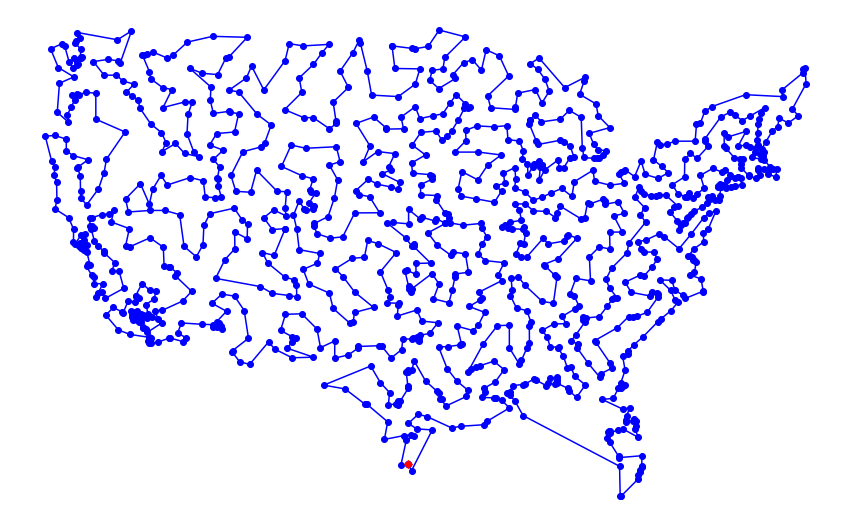

In [ ]:
do(improve_greedy_tsp, USA)

That's the best result yet,  and it only took 3 seconds!

What about a repetitive greedy algorithm?  That might be a good idea, but there is no obvious way to do it, because the greedy algorithm as it stands doesn't have a parameter that can be varied on each repeated run.
That's the best result so far, and it only took 3 seconds!


## Visualizing the Greedy Algorithm


We copy greedy_tsp to create a new improved version that adds a line to trace the segments several times while it is running and a line at the end to improve and trace the route

In [ ]:
def visualize_improve_greedy_tsp(cities, plot_sizes):
    """Go through links, shortest first. Use link to join segments if possible.
    Plot segments at specified plot_sizes."""
    endpoints = {c: [c] for c in cities} # A dict of {endpoint: segment}
    for (A, B) in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            plot_segments(endpoints, plot_sizes)
            if len(new_segment) == len(cities):
                plot_tour(new_segment)
                plt.show()
                do(improve_greedy_tsp, cities)
                return 
    
def plot_segments(endpoints, plot_sizes):
    "If the number of distinct segments is one of plot_sizes, then plot segments."
    segments = set(map(tuple, endpoints.values()))
    if len(segments) in plot_sizes:
        for s in segments:
            plot_segment(s)
        plt.show()

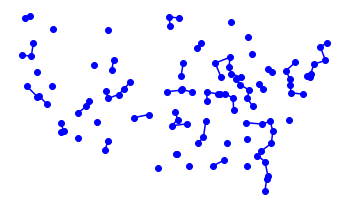

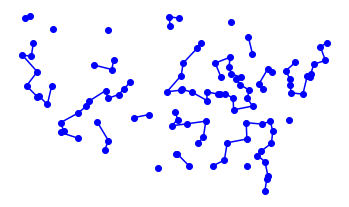

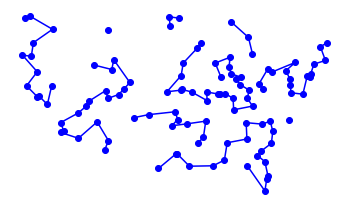

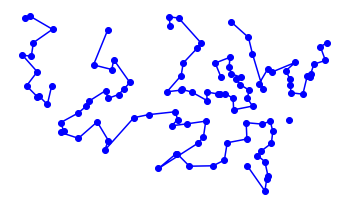

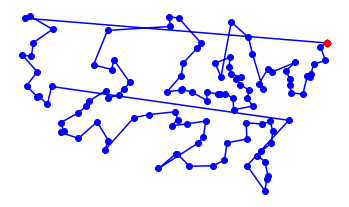

NameError: ignored

In [ ]:
visualize_improve_greedy_tsp(sample(USA, 110), {40, 20, 10, 5});

# Divide and Conquer Strategy

Another important strategy to consider is to divide and conquer, for example in an algorithm like exhaustive_tsp, it cannot be applied to many cities due to its inefficiency but it is possible to divide the problem into small pieces and combine them

1. Split the set of cities in half.
2. Find a tour for each half.
3. Join those two tours into one.

When *n* is small, then step 2 can be done directly by the inefficient algorithm.  But when *n* is large, step 2 is done with a recursive call, breaking each half into two smaller pieces.
Here's an example with six cities. We split them into two halves of 3 cities each, for which we can easily create tours:

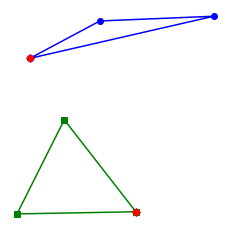

In [ ]:
d, a, b, e, c, f = Cities(6)

half1, half2 = [c, a, b], [d, e, f]

plot_tour(half1, 'bo-')
plot_tour(half2, 'gs-')

Now to join the two halves together, the first thing I do is delete a link from each half. There are 3 &times; 3 ways to do that; here's one:

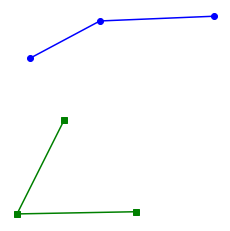

In [ ]:
plot_segment(half1, 'bo-')
plot_segment(half2, 'gs-')


Now I connect the two halves back together. There are two ways to do that; this is the better way:

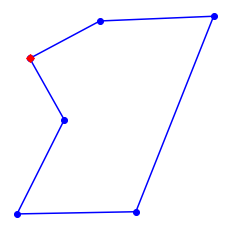

In [ ]:
plot_tour(half1 + half2)

 I'll call the divide and conquer algorithm `divide_tsp`.  If the size of the set of cities is *n* or less, then find the shortest tour using `exhaustive_tsp`. If there are more than *n* cities, then split the cities in half (with `split_cities`), find a tour for each half (using `divide_tsp` recursively), and join the two tours together (with `join_tours`): 

In [ ]:
def divide_tsp(cities, n=6):
    """Find a tour by divide and conquer: if number of cities is n or less, use exhaustive search.
    Otherwise, split the cities in half, solve each half recursively, 
    then join those two tours together."""
    if len(cities) <= n:
        return exhaustive_tsp(cities)
    else:
        half1, half2 = split_cities(cities)
        return join_tours(divide_tsp(half1), divide_tsp(half2))
    
# TO DO: functions: split_cities, join_tours

To partition a set of cities, one option is to imagine an axis-aligned rectangle that is large enough to contain all the cities. If the rectangle is wider than it is tall, sort all cities by x-coordinate and split the sorted list in half. If the rectangle is taller than it is wide, order and divide the cities by the y-coordinate.

In [ ]:
def split_cities(cities):
    "Split cities vertically if map is wider; horizontally if map is taller."
    width  = extent(list(map(X, cities)))
    height = extent(list(map(Y, cities)))
    cities = sorted(cities, key=(X if (width > height) else Y))
    middle = len(cities) // 2
    return cities[:middle], cities[middle:]

def extent(numbers): return max(numbers) - min(numbers)

To join two routes. We first consider all the ways to remove a link from each of the two traversals. If we remove a link from a tour, we get a segment. We're rendering segments as lists of cities, the same surface rendering as tours. But there is a difference in their interpretation. The path [c, a, b] is a three-link triangle, but the segment [c, a, b] consists of only two links, from c to a and from a to b. The segments that result from removing a link from the path [c, a, b] are:


     [c, a, b],  [a, b, c],  [b, c, a]

So any candidate combined tour consists of taking a rotation from the first tour and adding a rotation from the second tour to it. To add the two segments there are two ways to do it: keep the second segment as is, or invert the second segment.


In [ ]:
def join_tours(tour1, tour2):
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    return shortest_tour(s1 + s2
                         for s1 in segments1
                         for s  in segments2
                         for s2 in (s, s[::-1]))

def rotations(sequence):
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [sequence[i:] + sequence[:i] for i in range(len(sequence))]

As usual, we can define an **improved** version:

In [ ]:
def improve_divide_tsp(cities): return improve_tour(divide_tsp(cities))

Let's divide and conquer! First the 6 cities, then 100 USA cities:

divide, 3: 6 cities ⇒ tour length 1922 (in 0.001 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


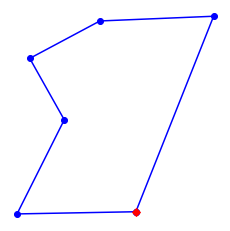

In [ ]:
do(bind(divide_tsp, 3), Cities(6))

In [ ]:
do(improve_divide_tsp, sample(USA, 110))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


TypeError: ignored

That's slightly better than `improve_greedy_tsp` (although it took 10 times longer).

# Shoulders of Giants: Minimum Spanning Tree Algorithm


| ![Joseph Kruskal (Wikipedia)](http://people.inf.elte.hu/hytruongson/Kruskal/J.Kruskal.jpg) |
|----|
| [Joseph Kruskal (Wikipedia)](https://en.wikipedia.org/wiki/Joseph_Kruskal) |





A tree is a directed graph in which there is a distinguished vertex called the root that has no parent; every other vertex has exactly one parent.

A spanning tree (of a set of vertices) is a tree that contains all the vertices.

A minimum spanning tree is a spanning tree with the smallest possible sum of link lengths.

A traversal of a tree is a way of visiting all the vertices in some order.

A preorder traversal means that it first visits the root and then performs a preorder traversal of each of the children.

A guarantee means that, regardless of the set of cities they consider, the path found by the minimum spanning-tree traversal algorithm will never be more than twice as long as the shortest possible path. None of the other algorithms have any guarantees (except exhaustive_tsp, which is guaranteed to find the optimal algorithm, if it has enough time to complete).

We will implement a directed graph as a dict of `{parent: [child, ...]}`. Now our plan is:

1. Implement an algorithm to create a minimum spanning tree.
2. Implement a tree traversal; that will give us our `mst_tsp` algorithm.
3. Understand the guarantee.

# Creating a Minimum Spanning Tree (`mst`)


Now let's see how to create a minimum spanning tree (or MST). 


> **[Prim's algorithm for creating a MST](http://en.wikipedia.org/wiki/Prim%27s_algorithm):** *List all the links and sort them, shortest first.  Initialize a tree to be a single root city (we'll arbitrarily choose the first city). Now repeat the following until the tree contains all the cities: find the shortest link that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.*

Here's the code. One tricky bit: In the first line inside the `while` loop, we assign `(A, B)` to be a link in which exactly one of `A` or `B` is in the tree, using the exclusive-or operator, `^`.  Then in the next line, we make sure that `A` is the one that is in the tree and B is not, by swapping if necessary.

In [ ]:
def mst(vertexes):
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form 
    {parent: [child...]}, spanning all vertexes."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    links = shortest_links_first(vertexes)
    while len(tree) < len(vertexes):
        (A, B) = first((A, B) for (A, B) in links if (A in tree) ^ (B in tree))
        if A not in tree: (A, B) = (B, A)
        tree[A].append(B)
        tree[B] = []
    return tree

Let's see what a minimum spanning tree looks like:

1089 node Graph of total length: 37868.3


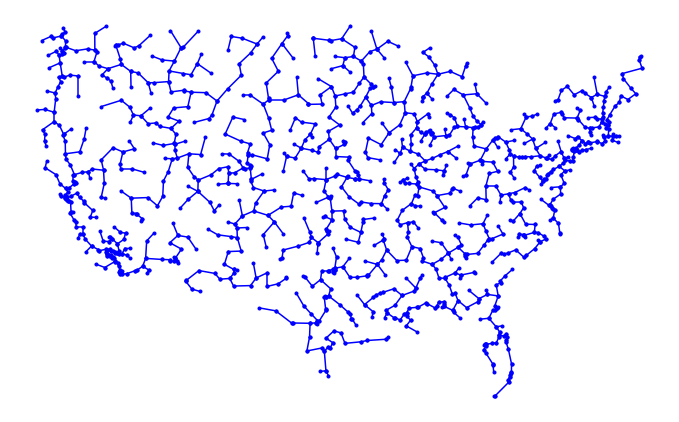

In [ ]:
def plot_graph(graph):
    "Given a graph of the form {parent: [child...]}, plot vertexes and links."
    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)
    links    = [(parent, child) for parent in graph for child in graph[parent]]
    total    = sum(distance(p, c) for (p, c) in links)
    print('{} node Graph of total length: {:.1f}'.format(len(vertexes), total))
    if len(graph) > 1000: plt.figure(figsize=(15, 7.5))
    for link in links:
        plot_segment(link, 'b.-')

    
plot_graph(mst(USA))

This certainly looks like a spanning tree.  But can we prove it is a minimum spanning tree?  

1. The output is a **tree** because (1) every city is connected by a path from the root, and (2) every city only gets one parent (we only add a B that is not in tree), so there can be no loops. 
2. The output is a **spanning tree** because it contains all the cities.
3. The output is a **minimum spanning tree** because each city was added with the shortest possible link.  Suppose this algorithm produces the tree T. For another putative spanning tree to be shorter, it would have to contain at least one city C whose link from its parent was shorter than the link in T. But that is not possible, because the algorithm always chooses the shortest possible link from C's parent to C.


# Turning a Minimum Spanning Tree into a Tour (`mst_tsp`)


Given a minimum spanning tree, we can generate a tour by doing a pre-order traversal, which means the tour starts at the root, then visits all the cities in the pre-order traversal of the first child of the root, followed by the pre-order traversals of any other children.

In [ ]:
def mst_tsp(cities):
    "Create a minimum spanning tree and walk it in pre-order, omitting duplicates."
    return Tour(preorder_traversal(mst(cities), first(cities)))

def preorder_traversal(tree, root):
    "Traverse tree in pre-order, starting at root of tree."
    yield root
    for child in tree.get(root, ()):
        yield from preorder_traversal(tree, child)
        
def improve_mst_tsp(cities): return improve_tour(mst_tsp(cities))

You can think of this as starting at the root of the tree and going around the outside of the tree, as if you were walking with your hand always touching a link, but skipping cities you have already been to.

Let's see what `mst_tsp` can do on the USA map:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


mst: 1089 cities ⇒ tour length 58059 (in 1.360 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


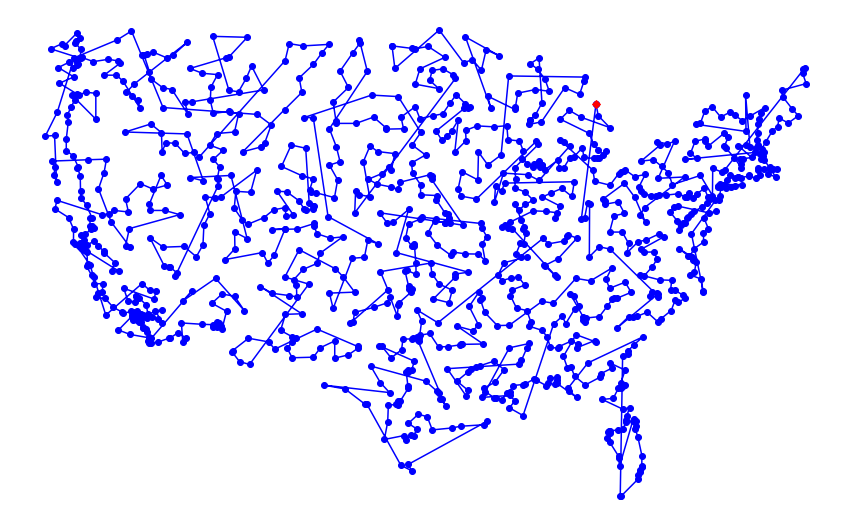

In [ ]:
do(mst_tsp, USA)

That's 5,000 miles worse than `nn_tsp`. Why would anyone want to use the minimum spanning tree algorithm, when the nearest neighbor algorithm is simpler to describe and implement, runs faster, and produces shorter tours? 

# Guaranteed Tour Length!

The "giant" thing about the minimum spanning tree algorithm is that it comes with a *guarantee*, which none of the other algorithms offer. The algorithm  guarantees that the tour length will be no worse than twice as long as the optimal tour.  (And, with a bit more [complication](https://en.wikipedia.org/wiki/Christofides_algorithm), you can modify it to give a guarantee of 1.5 times longer.)  The guarantee works like this:

1. The minimum spanning tree, by definition, connects all the cities with the shortest possible total link length.
2. So if you could follow each link in the spanning tree just once, and that formed a legal tour, then that would be guaranteed to be
a minimal tour.  
3. But you can't do that in general; in general there will be places where you skip to the next city without following the spanning tree.  Any such skip, however, is a straight line, and thus will be less than you would take if you went to the next city by following along the spanning tree.
4. If you did follow along the spanning tree, you would follow some links twice, and some links once.  Hence the total length of the tour would be at most twice the spanning tree, and thus at most twice the minimal tour.

A guarantee is great from a theoretical point of view, but in practice the greedy or nearest neighbor algorithms do better than the minimum spanning tree, and the improved versions of those algorithms do significantly better, on the maps that we actually see. 

# Shoulders of Giants: Held-Karp Algorithm: `held_karp_tsp`


| ![](http://imgs.xkcd.com/comics/travelling_salesman_problem.png) |
|----|
| [xkcd 399](http://xkcd.com/399/) |




 It is an algorithm for finding optimal tours, not approximate ones, so it is not appropriate for large *n*.  But even in its simplest form, without any programming tricks, it can go quite a bit further than `exhaustive_tsp`.  That is because `exhaustive_tsp` is O(*n*!), while the Held-Karp algorithm is only O(*n*<sup>2</sup> 2<sup>*n*</sup>).  How did Held and Karp achieve this speedup?  They noticed that `exhaustive_tsp` wastes a lot of time with permutations that can't possibly be optimal tours.  Here's the key idea:


>*Given a start city A, an end city C, and a set of middle cities Bs, then out of all the possible segments that start in A, end in C, and go through all and only the cities in Bs, only the shortest of those segments could ever be part of an optimal tour.*

Of course, we don't know that the optimal tour goes through exactly those Bs cities before hitting C.  But if it does, then we need only consider the permutation of Bs that leads to the shortest segment.  Why is that such a big deal? Suppose we are considering segments of the form:

     [A, {B1, ... B10}, C, {D1, ... D10}, E]
     
That is, segments that start with A, then have have 10 B<sub>i</sub> cities in some order, then C, then 10 D<sub>j</sub> cities in some order, then E. With the Exhaustive Search algorithm, we have to consider all orderings of B<sub>i</sub> and all orderings of D<sub>j</sub>, so overall there would be (10!)<sup>2</sup> &approx; 13 trillion orderings of this form. But with Held-Karp, we consider the B<sub>i</sub> and D<sub>j</sub> separately, and chose the best segment from each, giving us only 2 &times; 10! &approx; 7 million orderings to consider. (Actually it is even better than that, because we use Held-Karp recursively to split the B<sub>i</sub> and D<sub>j</sub> into pieces.) 


For this algorithm we start by declaring that A tends to be the first possible cities, so that we can then go through the tour and return the most optimal tours.

In [ ]:
def held_karp_tsp(cities):
    """The Held-Karp shortest tour of this set of cities.
    For each end city C, find the shortest segment from A (the start) to C.
    Out of all these shortest segments, pick the one that is the shortest tour."""
    A = first(cities)
    shortest_segment.cache_clear() # Start a new problem
    return shortest_tour(shortest_segment(A, cities - {A, C}, C)
                         for C in cities - {A})

# TO DO: function: shortest_segment(A, Bs, C)

Now for `shortest_segment(A, Bs, C)`, the shortest segment that starts in city `A`, ends in `C`, and visits some permutation of `Bs` cities in the middle.  If there are no `Bs` cities, then of course the shortest segment is to go directly from `A` to `C`.  If there are `Bs` cities, then one of them has to be the last `B` city visited (just before visiting `C`). So for each `B`, find the shortest segment that first goes from `A`, through all the other `Bs` cities, then to `B`, and finally to `C`.  Out of all these candidate segments, return the one with the minimum segment length.

**Note:** the decorator `@cache` makes this a **dynamic programming** algorithm, which is a fancy name meaning that we cache the results of sub-computations because we will re-use them multiple times. In the function `held_karp_tsp` we clear the cache at the start of each new problem.

In [ ]:
@cache(None)
def shortest_segment(A, Bs, C):
    "The shortest segment starting at A, going through all Bs, and ending at C."
    if not Bs:
        return [A, C]
    else:
        return min((shortest_segment(A, Bs - {B}, B) + [C] for B in Bs),
                   key=segment_length)
            
def segment_length(segment):
    "The total of distances between each pair of consecutive cities in the segment."
    # Same as tour_length, but without distance(tour[0], tour[-1])
    return sum(distance(segment[i], segment[i-1]) 
               for i in range(1, len(segment)))

That's all there is to it.  Let's compare `exhaustive_tsp` with `held_karp_tsp` on 10 city tours:

In [ ]:
do(exhaustive_tsp, Cities(10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


KeyboardInterrupt: ignored

In [ ]:
do(held_karp_tsp, Cities(10))

We see that `held_karp_tsp` is a lot faster.Their difference is approximately 14 seconds  We can extend into uncharted territory  beyond the reach of  `exhaustive_tsp`:

In [ ]:
do(held_karp_tsp, Cities(18))

Not bad! To see how much time we save using `held_karp_tsp` over `exhaustive_tsp`, we can extrapolate from the timings we've done, using the fact that Held-Karp is *O*(*n*<sup>2</sup> 2<sup>*n*</sup>) while Exhaustive Search is *O*(*n*!), to get this table:


|*n*|Exhaustive Search|Held Karp|
|---|---|---|
|10| 2 secs                | 0.04 secs |
|12|&approx; 4 mins   | 0.25 secs|
|15|&approx; 8 days |3 secs|
|18|&approx; 112 years| 43 secs|
|25|&approx; <a href="https://www.google.com/search?q=2+seconds*25!+%2F+10!+in+years">270 billion years</a>|&approx; 3 hours|
|50|&approx; 10<sup>50</sup> years</a>|&approx; 45,000 years|


So if we had the patience to wait 3 hours, `held_karp_tsp` could give us an answer that saves 270 billion years of computing with `exhaustive_tsp`.  The original Held-Karp algorithm had refinements that allowed it to handle 50-city sets in hours, not milleniums, and could do so even with 1970s-era computing power! See **Branch and Cut** below.

We have one more trick to try:

# Ensemble Strategy: `ensemble_tsp`

When we have several optimization algorithms and we're not sure which is best, we can always try them all and take the best result:

In [ ]:
ensemble = {rep_improve_nn_tsp, improve_greedy_tsp, improve_mst_tsp, improve_divide_tsp}

def ensemble_tsp(cities, algorithms=None): 
    "Apply an ensemble of algorithms to cities and take the shortest resulting tour."
    return shortest_tour(tsp(cities) for tsp in (algorithms or ensemble))

NameError: ignored

ensemble: 110 cities ⇒ tour length 14727 (in 0.388 sec)


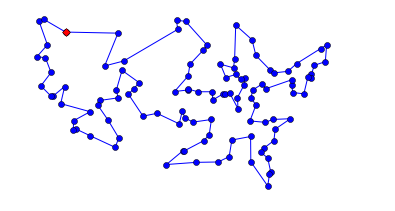

In [ ]:
do(ensemble_tsp, set(sample(USA, 110)))

# ***SECOND PART OF WORKSHOP***


# **Genetic algorithm**
A genetic algorithm is a search heuristic that is inspired by Charles Darwin’s theory of natural evolution. This algorithm reflects the process of natural selection where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.


The process of natural selection starts with the selection of fittest individuals from a population. They produce offspring which inherit the characteristics of the parents and will be added to the next generation. If parents have better fitness, their offspring will be better than parents and have a better chance at surviving. This process keeps on iterating and at the end, a generation with the fittest individuals will be found.

This notion can be applied for a search problem. We consider a set of solutions for a problem and select the set of best ones out of them.

Five phases are considered in a genetic algorithm.



*   **Initial population**
*   **Fitness function**
*   **Selection**
*   **Crossover**
*   **Mutation**



In [ ]:
def genetic_tsp(cities):
	'''
	Algoritmo Genetico
	'''
	toolbox = base.Toolbox()
	
	creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMin)
	
	toolbox.register("indices", numpy.random.permutation, len(cities))
	toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
	toolbox.register("population", tools.initRepeat, list, toolbox.individual)
	
	toolbox.register("mate", tools.cxOrdered)
	toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
	
	def create_tour(individual):
		return [list(cities)[e] for e in individual]
		
	def evaluation(individual):
		'''
		Evaluates an individual by converting it into
		a list of cities and passing that list to total_distance
		'''
		return tour_length(create_tour(individual)),
	
	toolbox.register("evaluate", evaluation)
	
	toolbox.register("select", tools.selTournament, tournsize=3)
	
	pop = toolbox.population(n=100)

	result, log = algorithms.eaSimple(pop, 
		toolbox,
		cxpb=0.8, 
		mutpb=0.2,
		ngen=40, 
		verbose=False)

	return create_tour(tools.selBest(result, k=1)[0])


In [ ]:
do(genetic_tsp, USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


KeyboardInterrupt: ignored

In [ ]:
def improve_genetic_tsp(cities): 
    "Improve the tour produced by nn_tsp."
    return improve_tour(genetic_tsp(cities))

In [ ]:
do(improve_genetic_tsp,USA)

As we can see, this genetic algorithm is not recommended if we are going to do it with many cities, since mainly it does not take all the options that exist, therefore, the tour will not be the most optimal. On the other hand, when working with permutations it can even take too many hours.

# **Genetic algorithm Chu Beasley**

In [ ]:
def chu_beasley_tsp(cities):
  '''
	Genetic Algorithm
	'''
  toolbox = base.Toolbox()
	
  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMin)
	
  toolbox.register("indices", numpy.random.permutation, len(cities))
  toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
	
  toolbox.register("mate", tools.cxOrdered)
  toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
	
  def create_tour(individual):
	  return [list(cities)[e] for e in individual]
		
  def evaluation(individual):
	  return tour_length(create_tour(individual)),
	
  toolbox.register("evaluate", evaluation)
	
  toolbox.register("select", tools.selTournament, tournsize=3)
  hof = tools.HallOfFame(1)
  pop = toolbox.population(n=1)
  
  result, log = algorithms.eaSimple(pop, 
		toolbox,
		cxpb=0.7, 
		mutpb=0.07,
		ngen=40,
    halloffame=hof,
		verbose=False)

  return create_tour(tools.selBest(result, k=1)[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


chu_beasley: 1089 cities ⇒ tour length 1113613 (in 0.120 sec)


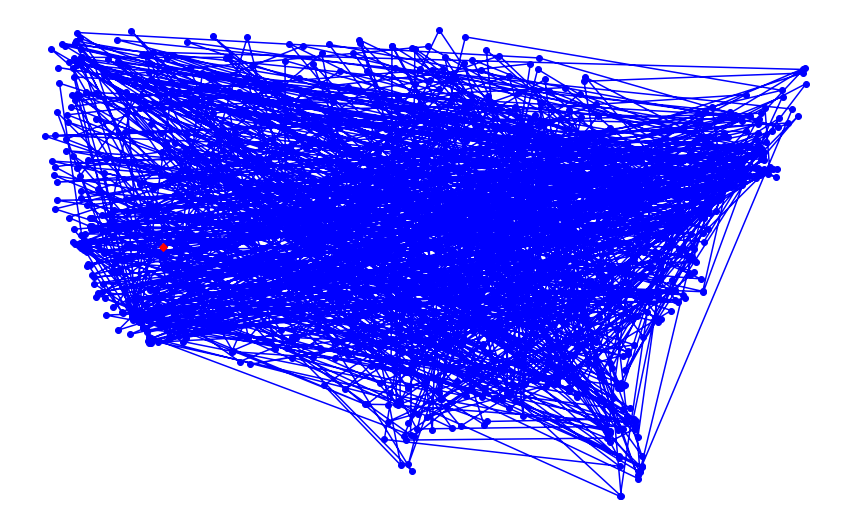

In [ ]:
do(chu_beasley_tsp,USA)

In [ ]:
def improve_chu_beasley_tsp(cities):return improve_tour(chu_beasley_tsp(cities))


In [ ]:
do(improve_chu_beasley_tsp,USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


# **Hill Climbing algorithm**

The Hill Climbing Algorithm is interesting to find a local optimum (a solution that cannot be improved considering a neighborhood configuration) but it does not guarantee to find the best possible solution (the global optimum) of all possible solutions (the search space). . The feature that only the local optimum can be guaranteed can be remedied using restarts (repeated local search), or more complex iteration-based schemes, such as iterated local search, in-memory, reactive search optimization and tabu search, or stochastic modifications. , such as simulated annealing.



> These are the libraries that we are going to use.



In [ ]:
!pip install simpleai
from simpleai.search import SearchProblem, hill_climbing_random_restarts

from simpleai.search.viewers import ConsoleViewer
import random

     |████████████████████████████████| 94 kB 1.9 MB/s 
  Created wheel for simpleai: filename=simpleai-0.8.3-py3-none-any.whl size=101000 sha256=d62d15743d8b25b9428ac59a208f6351a27be83c537b1fad2683f651ac7cee8e
  Stored in directory: /root/.cache/pip/wheels/9a/d1/3b/ef0fc9aee7197e62482fc629181119aaacb684225057516de3
Successfully built simpleai


In [ ]:
def hill_climbing_tsp(cities):
  class TSPProblem(SearchProblem):
      def __init__(self, cities):
    #Constructor de clases Problema del Agente Viajero
          self.cities = list(cities)
          super(TSPProblem, self).__init__(initial_state=random.sample(cities, len(cities)))
      def actions(self, state):
    #Retorna lista de actions con action description[0] y el tour[1] resultante
          actions = []
          
          num_cities = len(self.cities)
          x = random.randint(0, num_cities)
          y = random.randint(0, num_cities)
      # Escoge 2 puntos al azar hasta que sea valido para invertir el recorrido
          while x == y or y == min(x, y):
              x = random.randint(0, num_cities)
              y = random.randint(0, num_cities)
          
        # Invertir
          state = state[0:x+1] + list(reversed(state[x+1:y])) + state[y:]
          actions.append(('2-change at ' + str(x) + ' and ' + str(y), state))
          return actions


      def result(self, state, action):
    #Retorna recorrido resultante desde action
          return action[1]


      def value(self, state):
      #retirna la longitud del recorrido
          return - tour_length(state)


      def generate_random_state(self):

        return random.sample(self.cities, len(self.cities))
        

  problem = TSPProblem(list(cities))
  result = hill_climbing_random_restarts(problem,restarts_limit=300)
  return result.state

      


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


hill_climbing: 1089 cities ⇒ tour length 1078141 (in 1.195 sec)


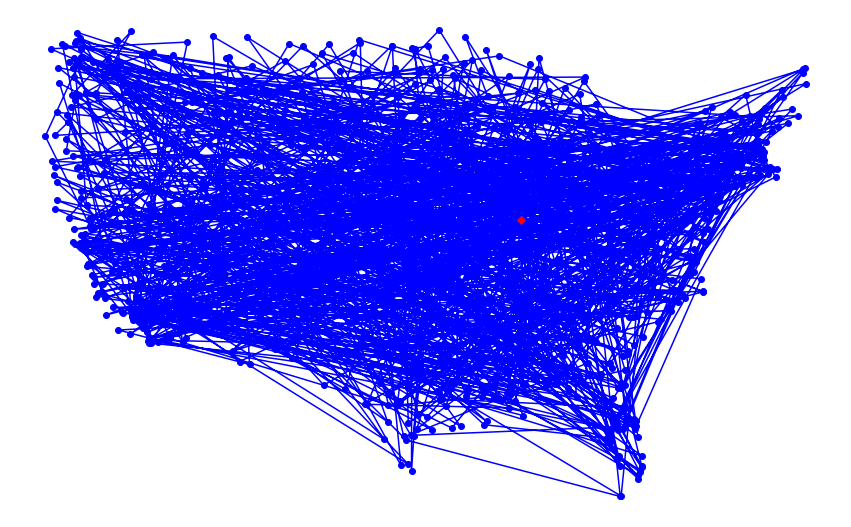

In [ ]:
do(hill_climbing_tsp,USA)

This algorithm can be really good, but we don't like it, since this algorithm has random restarts, the result of the tour can change every time it is executed. That is why we do not recommend this algorithm especially.

In [ ]:
def improve_hill_climbing_tsp(cities):
  return improve_tour(hill_climbing_tsp(cities))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


improve_hill_climbing: 1089 cities ⇒ tour length 46663 (in 6.376 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


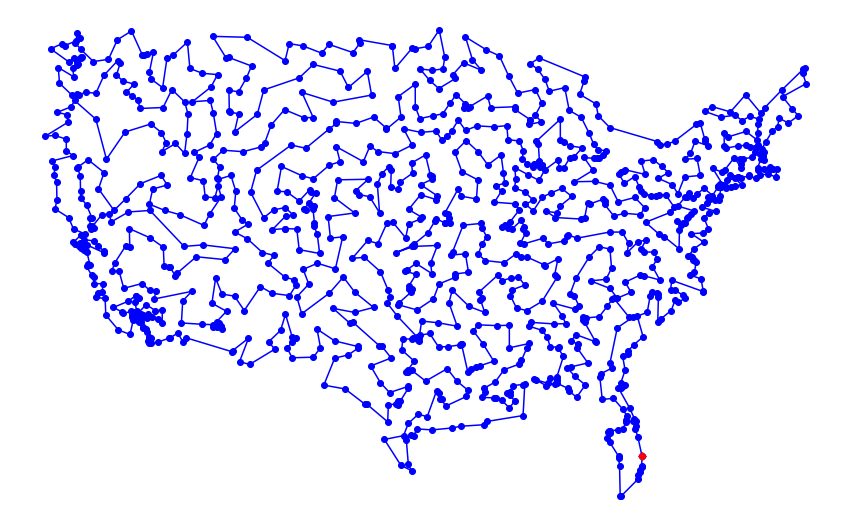

In [ ]:
do(improve_hill_climbing_tsp,USA)

# **Simulated Annealing algorithm**

In [ ]:
# tsp_annealing.py
# traveling salesman problem
# using classical simulated annealing
# python

import numpy as np

def simulated_annealing_tsp(cities):
	opt = 45000 # ????
	
	def error(route):
		n = len(route)
		d = tour_length(route)
		return d - 40000
		
	def adjacent(route):
		n = len(route)
		result = np.copy(route)
		i = np.random.randint(n)
		j = np.random.randint(n)
		tmp = result[i]
		result[i] = result[j]; result[j] = tmp
		return result
		
	def solve(cities, max_iter, start_temperature, alpha):
		# solving using simulated annealing
		curr_temperature = start_temperature
		soln = np.copy(cities)
		np.random.shuffle(soln)
		#print("Initial guess: ")
		#print(soln)
		
		err = error(soln)
		iteration = 0
		interval = (int)(max_iter / 10)
		while iteration < max_iter and err > 0.0:
			adj_route = adjacent(soln)
			adj_err = error(adj_route)
			
			if adj_err < err:  # better route so accept
				soln = adj_route; err = adj_err
			else:          # adjacent is worse
				accept_p = np.exp((err - adj_err) / curr_temperature)
				p = np.random.random()
				if p < accept_p:  # accept anyway
					soln = adj_route; err = adj_err
				# else don't accept
				
			if curr_temperature < 0.00001:
				curr_temperature = 0.00001
			else:
				curr_temperature *= alpha
			iteration += 1
			
		return soln

#	print("\nIniciando TSP simulated annealing demo ")
		
	num_cities = len(USA)
#	print("\nConfigurando num_cities = %d " % num_cities)
		
	np.random.seed(123)

	max_iter = 35000
	start_temperature = 1500.0
	alpha = 0.45
	
	#print("\nConfiguración: ")
	#print("max_iter = %d " % max_iter)
	#print("start_temperature = %0.1f " % start_temperature)
	#print("alpha = %0.2f " % alpha)
		
#	print("\nIniciando solve() ")
	soln = solve(list(USA), max_iter, start_temperature, alpha)
	#print("Finalizado solve() ")
		
		#print("\nMejor solución encontrada: ")
		#print(soln)
	dist = tour_length(soln)
		#print("\nTotal distancia = %0.1f " % dist)
		
	#print("\nFin demo ")
	return soln

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


simulated_annealing: 1089 cities ⇒ tour length 365014 (in 25.154 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


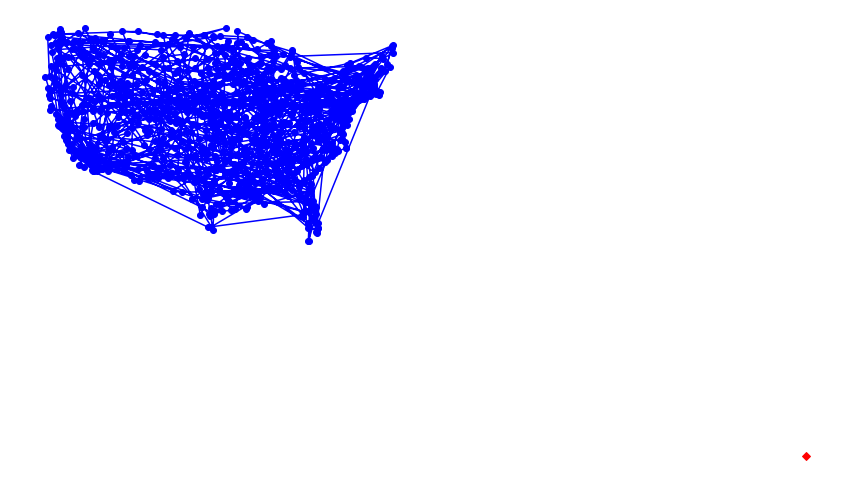

In [ ]:
do(simulated_annealing_tsp,USA)

In [ ]:
def improve_simulated_annealing_tsp(cities):
  return improve_tour(simulated_annealing_tsp(cities))

# **Best first Search Algorithm **
# A* , Heuristic (MST) 

In [ ]:
!pip install pytictoc

In [ ]:

from pytictoc import TicToc

def a_star(cities):
  class TravelingSalesmanProblem(Problem):
      """ The problem of finding the shortest
          way to perform Hemilton Circle between the cities"""

      def __init__(self, all_cities, initial, goal=None): # initial = (0), goal = some state that its first and last values are 0
          """ Define goal state and initialize a problem """
          super().__init__(initial, goal)
          self.cities_matrix = init_distance_matrix(all_cities)
          self.cities_identifiers = set(all_cities.keys())
          self.cities_amount = len(self.cities_identifiers)
          self.trees_evaluation_hash = {}
          self.t = TicToc()
          self.t.tic()

      def value(self, state):
          overall_distance = 0.0
          state_max_ind = len(state) - 1
          for ind, city in enumerate(state):
              if ind != state_max_ind:
                  overall_distance += self.cities_matrix[state[ind]][state[ind + 1]]
          return overall_distance

      def actions(self, state):
          """ Return the actions that can be executed in the given state.
          The result would be a list"""
          if len(state) == self.cities_amount:
              return [0]
          return self.get_unvisited_cities(state)

      def result(self, state, action):
          """ Given state and action, return a new state that is the result of the action.
          Action is assumed to be a valid action in the state """

          # blank is the index of the blank square
          new_state = list(state)
          new_state.append(action)
          return tuple(new_state)

      def goal_test(self, state):
          """ Given a state, return True if state is a goal state or False, otherwise"""
          return len(state) == (self.cities_amount + 1) and state[0] == state[self.cities_amount]

      def get_unvisited_cities(self, state):
          return self.cities_identifiers.difference(state)

      def h(self, node):
          h = 0.0
          visited_set = set(node.state)
          hashed_visited_set = hash(str(visited_set))
          unvisited_cities = self.get_unvisited_cities(node.state)
          # min edge from visited to unvisited
          #h += self.evaluate_visited_mst_connection_edge(node.state, node.state[-1], unvisited_cities)

          # MST evaluation
          if hashed_visited_set in self.trees_evaluation_hash.keys():
              h += self.trees_evaluation_hash[hashed_visited_set]
          else:
              mst_evaluation = self.eval_unvisited_mst_edges_sum_improved(unvisited_cities)
              self.trees_evaluation_hash[hashed_visited_set] = mst_evaluation
              h += mst_evaluation

          # min edge from unvisited to visited
          #h += self.evaluate_visited_mst_connection_edge(node.state, node.state[0], unvisited_cities)
          return h

      def eval_unvisited_mst_edges_sum_improved(self, unvisited_nodes):
          if int(self.t.tocvalue()) >= 600:
              self.t.toc('mst hash has been reset', True)
              self.reset_mst_eval_hash()
          if not unvisited_nodes:
              return 0.0
          return self.tsp_kruskal(unvisited_nodes)

      def path_cost(self, c, state1, action, state2):
          return c + self.cities_matrix[state1[-1]][state2[-1]]

      def evaluate_visited_mst_connection_edge(self, state, visited_city, unvisited_cities):
          min_connected_edge_weight = float('Inf')
          if not unvisited_cities:
              if state[-1] == state[0]:
                  return 0.0
              else:
                  return self.cities_matrix[state[-1]][visited_city]
          for unvisited_city in unvisited_cities:
              connected_edge_weight = self.cities_matrix[visited_city][unvisited_city]
              if connected_edge_weight < min_connected_edge_weight:
                  min_connected_edge_weight = connected_edge_weight
          return min_connected_edge_weight

      def tsp_kruskal(self, unvisited_nodes):
          forest_value = 0.0
          disjoint_sets = graph.DisjointSets()
          non_sorted_edges_list = []
          for vertex_x in unvisited_nodes:
              disjoint_sets.make_set(vertex_x)
              for vertex_y in unvisited_nodes:
                  if vertex_x < vertex_y:
                      non_sorted_edges_list.append((vertex_x, vertex_y))
          edges_list = sorted(non_sorted_edges_list, key=lambda edge: self.cities_matrix[edge[0]][edge[1]], reverse=False)
          for vertex_u, vertex_v in edges_list:
              if disjoint_sets.find(vertex_v) != disjoint_sets.find(vertex_u):
                  forest_value += self.cities_matrix[vertex_u][vertex_v]
                  disjoint_sets.union(vertex_v, vertex_u)
          return forest_value

      def reset_mst_eval_hash(self):
          self.trees_evaluation_hash = {}

  problem = TravelingSalesmanProblem(tuple(cities),None)
  result = astar_search(problem,'50000')
 

  return  result.solution

      

In [ ]:
do(a_star,USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


AttributeError: ignored

# **Taboo Search algorithm**

1.   Elemento de la lista
2.   Elemento de la lista



In [ ]:
!pip install utils

In [ ]:

import random
import math
import time
from itertools import combinations
from utils import *
import sys
#def tabu_tsp(cities):
class Tabu():
		def __init__(self, distance, seed = 0, limited_time = 600):
			# distance input: node_id, x, y
			self.cities = cities
			self.N = len(self.cities)
			self.best_tour = None
			self.best_cost = float("inf")
			self.seed = seed
			self.limited_time = limited_time
			self.nodes = [i for i in range(self.N)]
			self.cost_history = []
			
		def set_seed(self, seed):
			self.seed = seed
			
		def tabu(self, curr_tour = None, stopping_criteria = 30):
			'''
			Mantenga la lista tabú: realice un seguimiento de las 
			búsquedas recientes e inclúyalas en la lista tabú para 
			que el algoritmo 'explore' diferentes posibilidades.

			Pasos:			
			1. elige un estado inicial aleatorio
			2. entra en un bucle comprobando si se cumple una condición 
				de interrupción dada por el usuario (límite inferior)
			3. crea una lista de candidatos vacía.  Cada uno de los 
				candidatos en un vecino determinado que no contiene un 
				elemento tabú se agrega a esta lista de candidatos vacía
			4. Encuentra el mejor candidato en esta lista y si su costo 
				es mejor que el mejor actual, lo marca como una solución.
			5. Si el número de tabúes en la lista de tabúes ha alcanzado 
				el número máximo de tabúes (usted está definiendo el número), 
				un tabú caduca.  Los tabús de la lista expiran en el orden 
				en que se ingresaron... primero en entrar, primero en salir.
			'''
			N = len(self.distance)
			tabu_list = []
			tabu_list_limit = N*50
			
			# initialization
			sol_cost = tour_length(self, curr_tour)
			neighbor_swap = list(combinations(list(range(N)), 2))
			
			stop_criterion = 0
			changed = 0
			while time.time() - self.start_time < self.limited_time:
				best_tour, best_cost = [], float("inf")
				# get best solution in the neighbor
				random.shuffle(neighbor_swap)
				for neighbor in neighbor_swap[ : len(neighbor_swap) // 3]:
					i, j = neighbor
					# define a neighbor tour
					new_tour = curr_tour.copy()
					new_tour[i: (i + j)] = reversed(new_tour[i: (i + j)])
					
					new_cost = tour_length(self, new_tour)
					if new_cost <= best_cost and new_tour not in tabu_list:
						best_tour = new_tour
						best_cost = new_cost
						
				# stopping criterion:
				if stop_criterion > stopping_criteria and changed <= 10:
					changed += 1
					curr_tour, _ = greedy_tsp(self)
					
				if stop_criterion > stopping_criteria and changed > 10:
					break
					
					
				if len(tabu_list) == tabu_list_limit:
					tabu_list.pop()
					
				if not best_tour:
					best_tour = new_tour # accpet some worse solution to escape the local maximum
					stop_criterion += 1
					
				tabu_list.append(best_tour)
				
				if best_cost < sol_cost:
					curr_tour = best_tour.copy()
					sol_cost = best_cost
					
			if self.best_cost > sol_cost:
				self.best_cost = sol_cost
				self.best_tour = curr_tour
				self.cost_history.append((round(time.time() - self.start_time, 2), self.best_cost))
				
		def batch_tabu(self, times = 100, stopping_criteria = 10):
			self.start_time = time.time()
			for i in range(1, times + 1):
				if time.time() - self.start_time < self.limited_time:
					print(f"Iteration {i}/{times} -------------------------------")
					greedy_tour, _ = greedy_tsp(self)
					self.tabu(curr_tour = greedy_tour, stopping_criteria = stopping_criteria)
					print("Best cost obtained: ", self.best_cost)
					print("Best tour", self.best_tour)
					
					
		# def vis_tour(self, tour):
		#     N = len(self.distance)
		#     fig, ax = plt.subplots(1, 1)
		#     ax.plot([self.distance[tour[i % N]][1] for i in range(N+1)], [self.distance[tour[i % N]][2] for i in range(N+1)], 'xb-')
		#     fig.savefig("../img/curr_tour.png")
		
		# def vis_cost(self, cost):
		#     fig, ax = plt.subplots(1, 1, figsize = (15, 9))
		#     ax.plot(cost, "*")
		#     ax.tick_params(axis='both', labelsize=20)
		#     ax.set_xlabel("Iteration steps", fontsize = 20)
		#     ax.set_ylabel("Cost", fontsize = 20)
		#     fig.savefig("../img/hist_cost2.png")
		
		
		def main():
			distance = cities
			tabu = Tabu(distance)
			
			for seed_i in range(20, 30, 1):
				tabu.set_seed(seed_i)
				print("Seed", seed_i)
				tabu.batch_tabu(times = 200)
				print("Best solution", tabu.best_cost)


	



In [ ]:
do(tabu_tsp,USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


TypeError: ignored

# Review

Here are the algorithms we developed, sorted by strategy:

- **Brute Force Strategy**: `exhaustive_tsp`
- **Greedy Strategy**: `nn_tsp`, `greedy_tsp`
- **Divide and Conquer Strategy**: `divide_tsp`
- **Ensemble Strategy**: `rep_nn_tsp`, `ensemble_tsp`
- **Giant Shoulders Strategy**: `mst_tsp`, `held_karp_tsp`
- **Iterative Improvement Strategy**: `improve_nn_tsp`, `improve_greedy_tsp`, `improve_divide_tsp`,  `rep_improve_nn_tsp`, `improve_mst_tsp`


# Benchmark Experiments on Algorithms

Which algorithm is best? I can't tell by trying them on only one or two problems. What I need to do is **benchmark** each algorithm on a standard **test suite** of problems. If the test suite is large enough, the results will have statistical significance. First we'll define `TestSuite`. It passes a different `seed` to `sample` each time, so we get a different set of cities each time.

In [ ]:
def TestSuite(n, k, cities=USA):
    "Return n different samples from cities, each consisting of k cities."
    return tuple(frozenset(sample(cities, k, seed=(n, k, i)))
                 for i in range(n))

In [ ]:
# A tiny test of sets of 2 cities each:
TestSuite(4, 2)

(frozenset({(-3804+2908.35j), (-3847.2000000000003+1798.83j)}),
 frozenset({(-3512.6400000000003+2915.94j), (-3623.04+2611.65j)}),
 frozenset({(-4736.64+3237.48j), (-4761.6+2439.15j)}),
 frozenset({(-3435.84+2840.73j), (-4353.6+2925.6j)}))

Next, the function `benchmark` takes as input a TSP function and a test suite, runs the function on each city set in the suite, and returns two values: the list of tour lengths that the function produced, and the average run time of the function. (Note that I *cache* the results, so that if you call benchmark a second time, and it has already done the computation, it just looks up the result rather than tediously re-running it. Note also that I round the tour lengths at 4 digits past the decimal place, because I don't want a round-off error to proclaim one tour better than another when they actually have the same length.)

In [ ]:
@cache(None)
def benchmark(algorithm, tests):
    "Benchmark one TSP algorithm on a test suite; return ([tour_lengths], average_time)"
    t0      = clock()
    lengths = [round(tour_length(algorithm(cities)), 4) for cities in tests] 
    t1      = clock()
    return lengths, (t1 - t0) / len(tests)

# Boxplots

A **boxplot** is a standard statistical visualization tool. I'll plot first,  explain later. 

In [ ]:
def boxplots(algorithms, tests):
    "Draw a boxplot for each of the functions executing the tests."
    lengthlists, times = unzip(benchmark(tsp, tests) for tsp in algorithms)
    best   = min(map(median, lengthlists))
    labels = [boxplot_label(A, L, T, best) 
              for (A, L, T) in zip(algorithms, lengthlists, times)]
    plt.figure(figsize=(15, 7.5))
    plt.grid(axis='y')
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.boxplot(lengthlists, labels=labels, showmeans=True, whis=(10, 90), sym='o', notch=True)
    plt.title("Comparison  on {} sets of Cities({})"
              .format(len(tests), len(tests[0])), fontsize=14)

def boxplot_label(tsp, lengths, T, best):
    return '{}\n{:.0f} ms\n{:.0f} mean len\n{:.0f} med len\n{:.3f} med ratio'.format(
           name(tsp), T * 1000, mean(lengths), median(lengths), median(lengths) / best)

def unzip(sequences): return zip(*sequences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


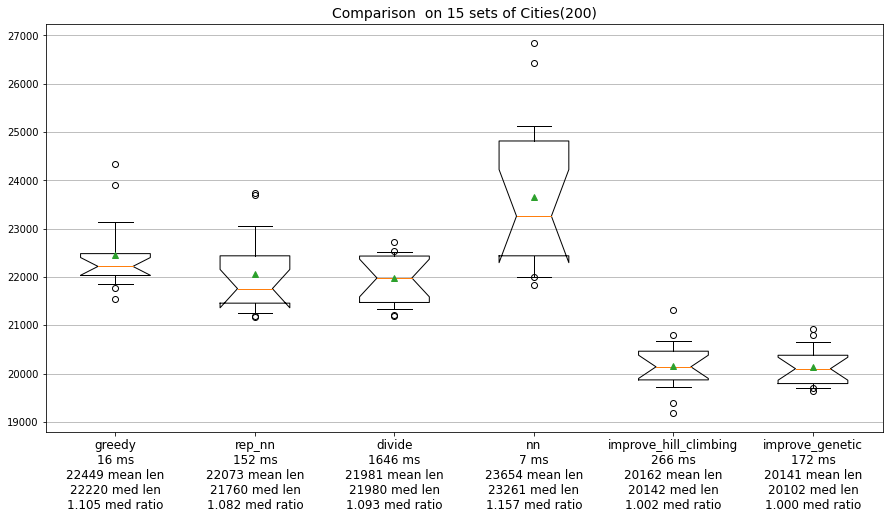

In [ ]:
# boxplots for the 5 basic approximate algorithms:

# mst_tsp FALTA
basic5 = [greedy_tsp, rep_nn_tsp, divide_tsp, nn_tsp,hill_climbing_tsp,genetic_tsp,chu_beasley_tsp]

boxplots(basic5, TestSuite(15, 200))

Each column represents a data set (in this case, the 15 tour lengths for one algorithm, **We put only 15 for speed of execution**) with a box covering the first to third quartiles of the data; inside the box is a horizontal line indicating the median and a marker indicating the mean. The 10% and 90%  intervals are the "whiskers" coming out of the top and bottom of the box, and individual points outside that range are shown as dots. The "notches" in the sides of a boxes represent the 95% confidence interval on the median: if two boxes' notches do not overlap, that is strong evidence that the true medians of the algorithms differ. The **label** at the bottom of each column gives the name of the algorithm, the average run time in milliseconds, the mean and median tour length, and the ratio of the median tour length of this algorithm to the median tour length of the best algorithm in this boxplot.

This plot says that the first three algorithms all did about the same in tour length; their notches overlap, so we can't be confident that one is better than the others. (Although we can be confident that the greedy algorithm is much faster.) The minimum spanning tree algorithm produces by far the longest tours. Nearest neighbor is fastest, while divide and conquer is slowest.

# Rankings

I'd also like to know for how many different problems each algorithm was best, or second best, etc. I will define a function called `rankings` to do that. I'll also define  `compare` to call both `boxplots` and `rankings`:

In [ ]:
def rankings(algorithms, tests):
    "Print a table of how often each algorithm had each rank: you get a #1 if you were shortest."
    N = len(algorithms)
    lengthlists = [benchmark(tsp, tests)[0] for tsp in algorithms]
    # ordered[i] is all tour lengths (for all algorithms) for the i-th problem, sorted
    ordered = [sorted(L) for L in zip(*lengthlists)]
    fmt = ('{:>4}' * len(algorithms) + ' | {}').format
    print(fmt(*['#' + str(i + 1) for i in range(N)], 'Algorithm'))
    print(' ---' * N + ' | ---------')
    for alg, lengths in zip(algorithms, lengthlists):
        ranks = Counter(ordered[i].index(lengths[i]) for i in range(len(tests)))
        print(fmt(*[ranks[i] for i in range(N)], name(alg)))

In [ ]:
rankings(basic5, TestSuite(50, 200))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


  #1  #2  #3  #4  #5  #6 | Algorithm
 --- --- --- --- --- --- | ---------
   0   1  10  16  20   3 | greedy
   0   3  14  15  17   1 | rep_nn
   0   0  21  15   9   5 | divide
   0   0   1   4   4  41 | nn
  23  26   1   0   0   0 | improve_hill_climbing
  27  20   3   0   0   0 | improve_genetic


The top line of the rankings says the greedy algorithm was #1 (had the shortest tour) for 14 out of the 50 problems, came in second  for 17 problems,  third 14 times, and fourth 5 times. The `rep_nn_tsp` algorithm was similar, coming in first 16 times; divide and conquer had the most first-place finishes with 20, and the MST algorithm was terrible, coming in last 34 times.

# Comparsion of Improved Algorithms

Now let's compare the **improved** versions of these algorithms (using `compare` to do boxplots and rankings):

In [ ]:
def compare(algorithms, tests=TestSuite(50, 200)):
    "Compare TSP algorithms on a test suite."
    boxplots(algorithms, tests)
    plt.show()
    rankings(algorithms, tests)

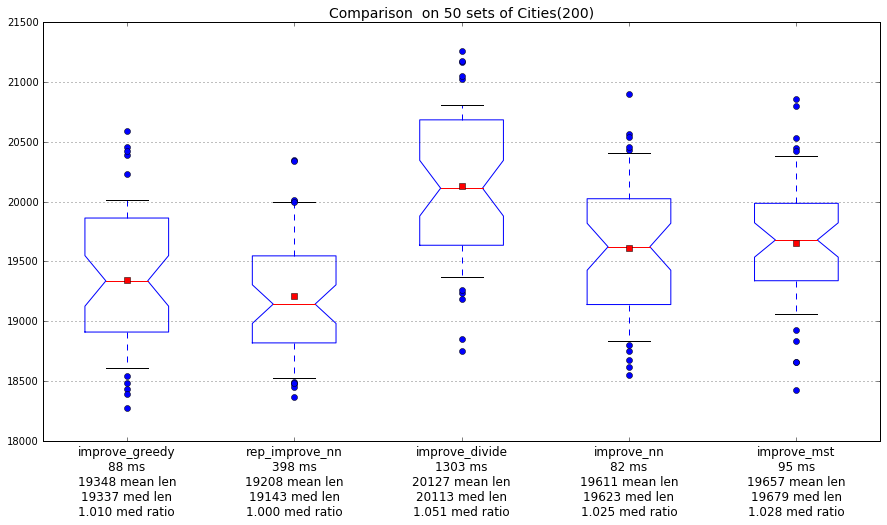

  #1  #2  #3  #4  #5 | Algorithm
 --- --- --- --- --- | ---------
  17  16   8   8   1 | improve_greedy
  26  16   6   2   0 | rep_improve_nn
   0   2   4   6  38 | improve_divide
   3  10  15  19   3 | improve_nn
   4   6  17  15   8 | improve_mst


In [ ]:
improved = [improve_greedy_tsp, rep_improve_nn_tsp, improve_divide_tsp, improve_nn_tsp, improve_mst_tsp, improve_genetic_tsp, improve_hill_climbing_tsp]

compare(improved)

The `improve_greedy_tsp` and `rep_improve_nn_tsp` algorithms give the shortest tours. One surprising result is that the divide and conquer algorithm was not improved much; perhaps the re-assembly steps of divide and conquer are already doing similar things to what `improve_tour` does. The minimum spanning tree algorithm is no longer terrible.


# Comparison of *k* Values for `rep_improve_nn_tsp`

What's a good value for the *k* parameter for the repetitive improved nearest neighbor algorithm?

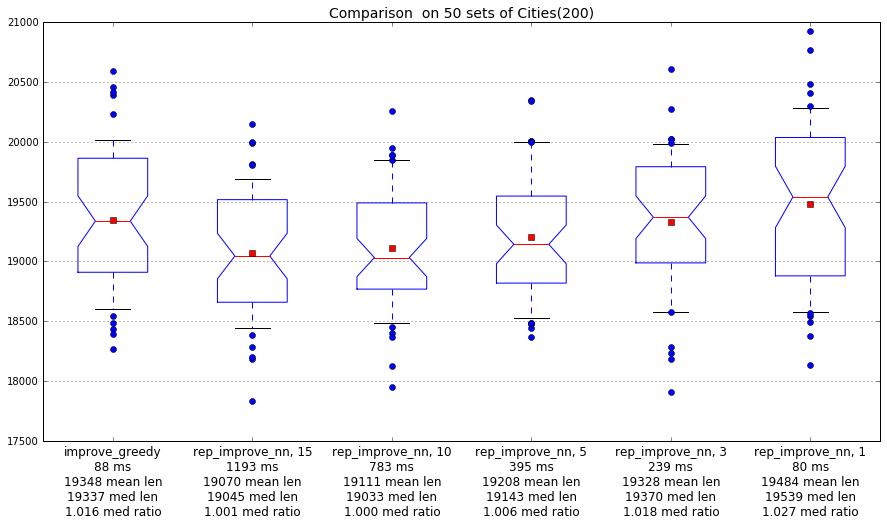

  #1  #2  #3  #4  #5  #6 | Algorithm
 --- --- --- --- --- --- | ---------
  10   4   1  11  12  12 | improve_greedy
  17  17  10   6   0   0 | rep_improve_nn, 15
  15   9  17   5   2   2 | rep_improve_nn, 10
   8   8   8  12   9   5 | rep_improve_nn, 5
   5   5   7  10  12  11 | rep_improve_nn, 3
   1   4   8   4  13  20 | rep_improve_nn, 1


In [ ]:
compare([improve_greedy_tsp] + [bind(rep_improve_nn_tsp, k) for k in (15, 10, 5, 3, 1)])

We do get shorter tours as we increase the reptitions, but of course we pay a penalty in run time. With *k*=3,
`rep_improve_nn_tsp` is roughly comparable to `improve_greedy_tsp` (although the later is twice as fast). With *k*=15 the tours are 2.5% shorter than with *k*=1, but the run time is 15 times longer. 

# Comparison of Ensemble Strategy

Since no one algorithm always dominates the others, maybe it is time for the **ensemble strategy**:

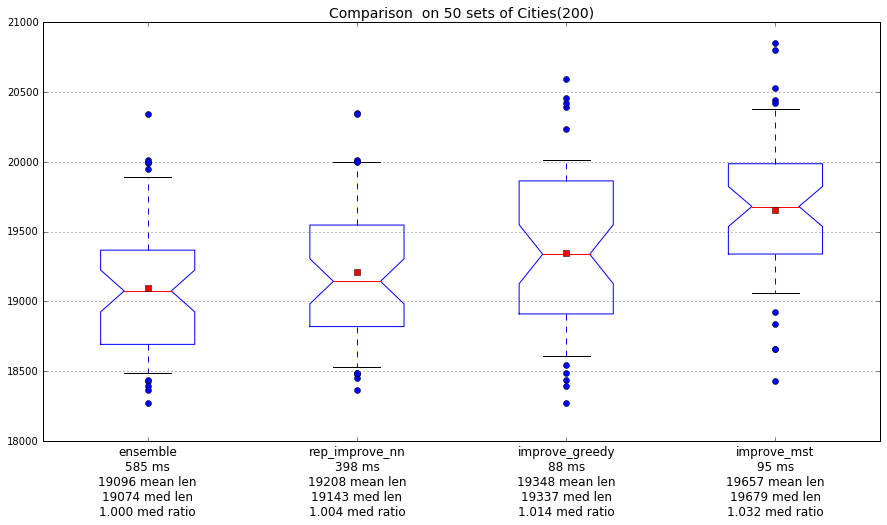

  #1  #2  #3  #4 | Algorithm
 --- --- --- --- | ---------
  50   0   0   0 | ensemble
  28   0  19   3 | rep_improve_nn
  18   0  20  12 | improve_greedy
   4   0  11  35 | improve_mst


In [ ]:
ensemble = (rep_improve_nn_tsp, improve_greedy_tsp, improve_mst_tsp, improve_genetic_tsp, improve_hill_climbing_tsp)

compare((ensemble_tsp, *ensemble))

The `ensemble_tsp` algorithm produces the shortest tours yet, because it gets contributions from both `rep_improve_nn_tsp` and `improve_greedy_tsp` (and, for just 4 out of 50 problems, from `improve_mst_tsp`). Note that in the rankings, for every problem there is a two way tie for first between the `ensemble_tsp` algorithm and whichever member of the ensemble contributed that tour. That's why there are 100 (not 50) entries in the "#1" column, and 0 in the "#2" column. 

Let's see if the results are different for different-sized city sets:

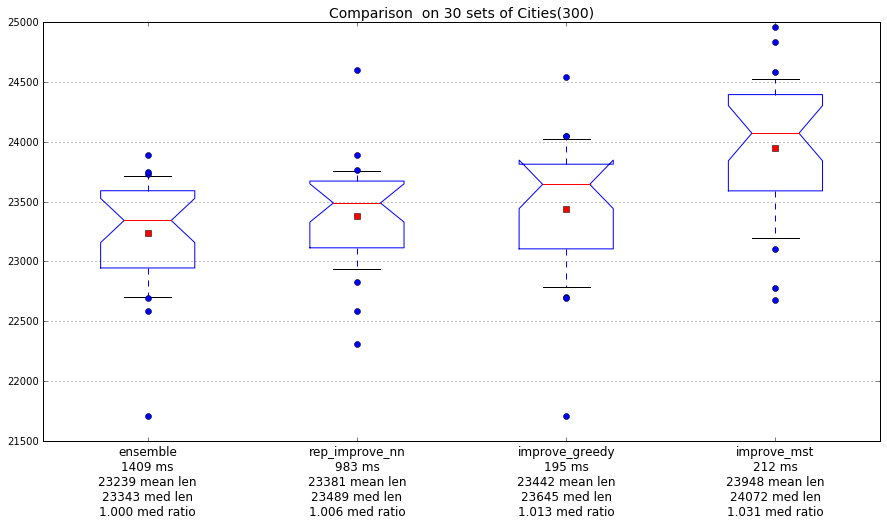

  #1  #2  #3  #4 | Algorithm
 --- --- --- --- | ---------
  30   0   0   0 | ensemble
  14   0  15   1 | rep_improve_nn
  14   0  12   4 | improve_greedy
   2   0   3  25 | improve_mst


In [ ]:
compare((ensemble_tsp, *ensemble), TestSuite(30, 300))

A similar picture.

# Comparing Precise Algorithms

Here I compare the two precise algorithms, Exhaustive Search and Held-Karp, to the (approximate) ensemble algorithm. I'll try both 9 and 10-city test suites:

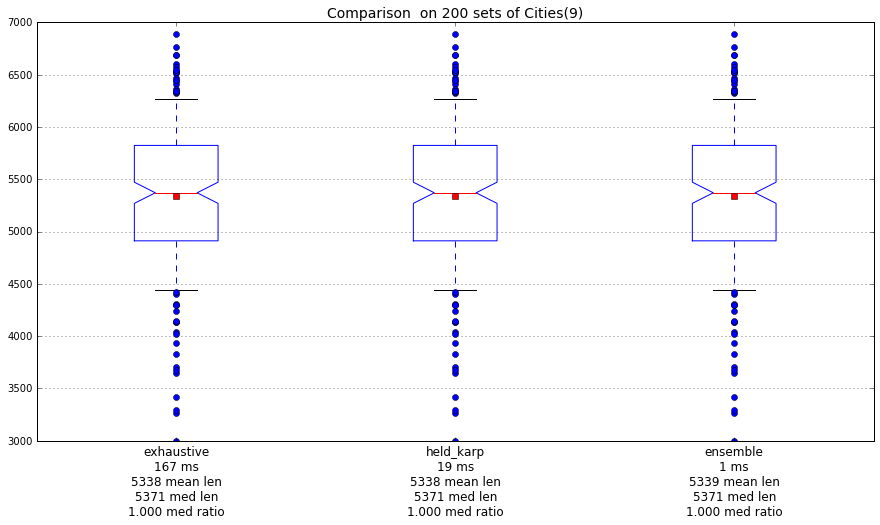

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
 200   0   0 | exhaustive
 200   0   0 | held_karp
 194   0   6 | ensemble


In [ ]:
compare([exhaustive_tsp, held_karp_tsp, ensemble_tsp], TestSuite(200, 9))

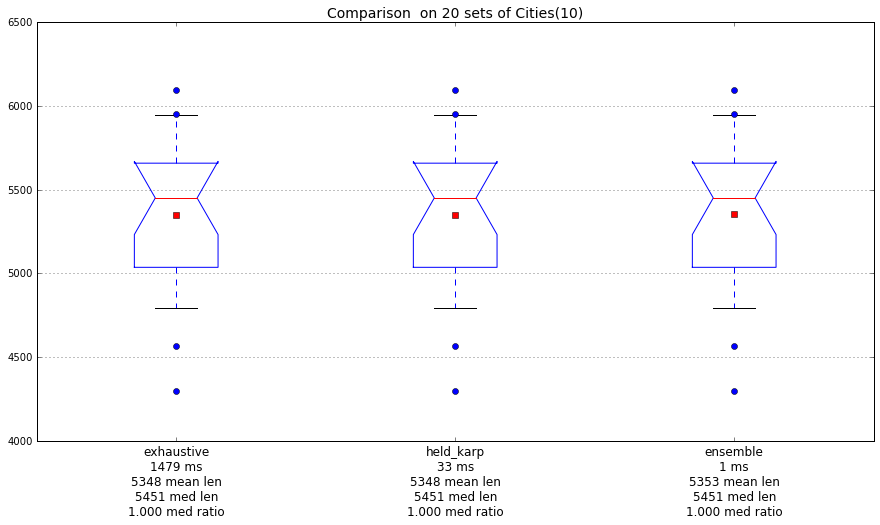

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
  20   0   0 | exhaustive
  20   0   0 | held_karp
  19   0   1 | ensemble


In [ ]:
compare([exhaustive_tsp, held_karp_tsp, ensemble_tsp], TestSuite(20, 10))

This says that while `ensemble_tsp` does not quite give a guarantee of an optimal tour, in practice on random city sets it performs almost exactly the same as the precise algorithms, only faster.


# Further Explorations


That's all I'm going to write for now.  But there are still plenty of open questions for you to explore:

* **Branch and Cut**: this is a technique to cut off a search early, when a partial solution is obviously not optimal.  We saw how Held-Karp cuts off some permutations of cities when another permutation is better.  A refinement on that is to keep track of, say, the best total length of the segment going through all the Bs cities.  Then, any time you have a partial segment through some of the Bs cities that exceeds the best total, we can stop right there, before even finishing all the Bs.  With this technique, you can find optimal tours for around 50 cities.
* **Linear programming**: Look up the topic "linear programming" and see how it applies to TSP.
* **Heuristic Algorithms**: There are many approaches for using heurisitic estimates to find good (but not optimal) tours.  For example, *ant colony optimization algorithms* make random choices of which link to follow, and then the links that occur in the best tours get reinforced with some virtual pheromones, and other ants tend to follow those pheromones. *Simulated annealing* takes its inspiration from metallurgy.
* The **[Lin-Kernighan heuristic](http://akira.ruc.dk/~keld/research/LKH/LKH-1.3/DOC/LKH_REPORT.pdf)** is a generalization of `improve_tour` that sometimes splits the tour into three pieces, not two, and considers all ways to put it back together. With this and other tricks, approximate algorithms  can handle hundreds of thousands of cities and come within 0.01% of the shortest possible tour.
* The **[Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm)** gives a guarantee of 3/2 the optimal tour length (improving on the minimum-spanning-tree guarantee of 2).
* **improved** as a function: we defined a lot of one-line functions that just call another algorithm, and then call `improve_tour` on the result.  Can you write a function, `improved(algorithm)`, which takes a TSP algorithm as argument, and returns an improved TSP algorithm that does the original algorithm and then calls `improve_tour` on the result? Make sure it handles extra arguments, and has a readable function name.
* Why does `mst_tsp` produce a guaranteed result, while `greedy_tsp` does not, even though the two algorithms have similar structure in the way they iterate over `shortest_links_first`?
* The code in this notebook was designed for clarity, not efficiency.  Can you make the code faster?
* **[William Cook](https://www.math.uwaterloo.ca/~bico/)** has a comprehensive 
[web page](http://www.math.uwaterloo.ca/tsp/) on the TSP, as well as a great 
[book](https://press.princeton.edu/titles/9531.html) and a
[draft chapter](http://www.math.uwaterloo.ca/~bico/papers/comp_chapter1.pdf) on Discrete Optimization featuring TSP. Like my notebook here, Cook's chapter goes through a variety of algorithms for TSP, describing each one in prose and code. His coding style is different because he uses C (in an imperative style) while I used Python (in a functional style).  His code is much more efficient (but if it is 100 times faster, that might only mean two more cities). Cook  chooses a different set of algorithms to explore, with
more emphasis on optimizing algorithms that find guaranteed shortest tours. I find his explanations and code
are both beautiful and concise, and I think it is very interesting that
there can be two quite different approaches, which (in my opinion) both turn out very well. 
* If you are heavily into math, there's a [taxonomy](http://cstheory.stackexchange.com/questions/9241/approximation-algorithms-for-metric-tsp) of solutions.
* What else are you interested in?


## **Here are the algorithms we developed, sorted by strategy:**

- Genetic algorithm : genetic_tsp
- Genetic algorithm chu beasley : chu_beasley_tsp
- Hill climbing algorithm: hill_climbing_tsp
- Simulated Annealing algorithm: simulated_annealing_tsp
- Best first Search Algorithm : Bfs_tsp
- taboo Search algorithm : taboo_search_tsp

# Benchmark Experiments on Algorithms

Which algorithm is best? I can't tell by trying them on only one or two problems. What I need to do is **benchmark** each algorithm on a standard **test suite** of problems. If the test suite is large enough, the results will have statistical significance. First we'll define `TestSuite`. It passes a different `seed` to `sample` each time, so we get a different set of cities each time.

In [ ]:
def TestSuite(n, k, cities=USA):
    "Return n different samples from cities, each consisting of k cities."
    return tuple(frozenset(sample(cities, k, seed=(n, k, i)))
                 for i in range(n))

In [ ]:
# A tiny test of sets of 2 cities each:
TestSuite(4, 2)

(frozenset({(-3804+2908.35j), (-3847.2000000000003+1798.83j)}),
 frozenset({(-3512.6400000000003+2915.94j), (-3623.04+2611.65j)}),
 frozenset({(-4736.64+3237.48j), (-4761.6+2439.15j)}),
 frozenset({(-3435.84+2840.73j), (-4353.6+2925.6j)}))

# **Ours conclutions**

We consider that the function improve tour is the most significant tool to improve the algorithms that we work.

The worst algorithm is the exhaustive one since it manages a strategy of permutations, and for the example of the cities of the united states it is very heavy at the computational level and of the algorithms that we had to implement, the worst is the genetic one since it has to do permutations but from a smaller population.

We had problems implementing the taboo algorithm and the A* algorithm, but the others work very well.

This notebook was made by:


*   **Nicolas Moreno**
*   **Leonardo Trejos**

